# Relacionando Deter e Prodes

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np

import prodes as pr
import utils as xu

## Funções

In [2]:
def add_deflorestation_frac(df):
    """
    Compute the ratio between deflorested
    area and original florest area for Prodes
    and Deter estimates and add both as 
    columns.
    """
    df['frac_incremento'] = df['Incremento'] / df['Desmatavel']
    df['frac_area_deter'] = df['area_deter'] / df['Desmatavel']
    
    return df

In [3]:
def estimate_model_error(model, prodes_deter_uf_anual, 
                         area_cols=['Incremento', 'AreaKm2', 'Desmatado', 'Floresta', 'Nuvem', 'NaoObservado', 'NaoFloresta', 'Hidrografia', 'Desmatavel', 'Disponivel', 'area_deter']):

    test_scores  = []
    train_scores = []
    area_br = prodes_deter_uf_anual.groupby('ano_prodes')['Desmatavel'].sum().mean()
    measured_years = prodes_deter_uf_anual['ano_prodes'].unique()

    for yr in measured_years:

        # Get other years as training:
        train_yr_df = prodes_deter_uf_anual.loc[prodes_deter_uf_anual['ano_prodes'] != yr]
        test_yr_df  = prodes_deter_uf_anual.loc[prodes_deter_uf_anual['ano_prodes'] == yr]
        # Get one year as test, and aggregate it:
        test_yr_df = test_yr_df.groupby('ano_prodes')[area_cols].sum()
        test_yr_df['frac_area_deter'] = test_yr_df['area_deter'] / area_br
        test_yr_df['frac_incremento'] = test_yr_df['Incremento'] / area_br

        # Get variables:
        X_train = train_yr_df[['frac_area_deter']].values
        y_train = train_yr_df['frac_incremento'].values
        X_test  = test_yr_df[['frac_area_deter']].values
        y_test  = test_yr_df['Incremento'].values

        # Fit & predict:
        w = train_yr_df['weight']
        dump = model.fit(X_train, y_train, fit__sample_weight=w)
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test) * area_br

        # Save score:
        train_scores.append(mean_squared_error(y_train * area_br, y_train_pred * area_br, squared=False))
        test_scores.append(mean_squared_error(y_test, y_test_pred))

    model_error = np.sqrt(np.mean(test_scores))
    return model_error

## Carregando dados

In [4]:
# Carregando dados de desmatamento do Prodes:
prodes_df = pr.etl_prodes_data('../dados/brutos/desmatamento/prodes/prodes_DesmatamentoMunicipios', 2010, 2020)

# Agregando dados do desmatamento por UF:
prodes_uf = prodes_df.groupby(['Estado', 'Ano'])[pr.areas_col].sum()
prodes_uf = prodes_uf.reset_index()
prodes_uf.rename({'Estado': 'UF', 'Ano': 'ano_prodes'}, axis=1, inplace=True)

# Agregando dados no Brasil:
prodes_br = prodes_df.groupby(['Ano'])[pr.areas_col].sum()
prodes_br = prodes_br.reset_index()
prodes_br.rename({'Estado': 'UF', 'Ano': 'ano_prodes'}, axis=1, inplace=True)

In [5]:
# Carregando dados do Deter:
deter_ref = pd.read_csv('../dados/brutos/desmatamento/terrabrasilis_deter/deter_desmatamento_ano-referencia_2021-08-19.csv')
deter_ref['ano_prodes'] = deter_ref['year'].str.extract('/(\d{4})', expand=False).astype(int)
deter_ref = deter_ref.loc[~deter_ref['uf'].isnull()]

### Modelo anual

In [6]:
# Agregado anual:
deter_uf_agg = deter_ref.groupby(['uf', 'ano_prodes'])['area'].sum().reset_index()
deter_uf_agg.rename({'uf': 'UF', 'area': 'area_deter'}, axis=1, inplace=True)
deter_br_agg = deter_ref.groupby(['ano_prodes'])['area'].sum().reset_index()
deter_br_agg.rename({'uf': 'UF', 'area': 'area_deter'}, axis=1, inplace=True)

In [7]:
# Junta os dados:
prodes_deter_uf_anual = prodes_uf.merge(deter_uf_agg, how='left', on=['ano_prodes', 'UF'])
prodes_deter_uf_anual = prodes_deter_uf_anual.loc[prodes_deter_uf_anual['ano_prodes'] >= deter_uf_agg['ano_prodes'].min()]
prodes_deter_br_anual = prodes_br.merge(deter_br_agg, how='left', on='ano_prodes')
prodes_deter_br_anual = prodes_deter_br_anual.loc[prodes_deter_br_anual['ano_prodes'] >= deter_br_agg['ano_prodes'].min()]

# Calcula desmatamento em termos da área desmatável do estado:
prodes_deter_uf_anual = add_deflorestation_frac(prodes_deter_uf_anual)
prodes_deter_br_anual = add_deflorestation_frac(prodes_deter_br_anual)

# Adiciona pesos (para o ajuste linear) na base de dados:
prodes_deter_uf_anual['weight'] = (prodes_deter_uf_anual['Desmatavel'] ** 2) / prodes_deter_uf_anual['Incremento'] / 1e7

# Fill missing Deter data:
prodes_deter_uf_anual.fillna(0, inplace=True)

area_cols = ['Incremento', 'AreaKm2', 'Desmatado', 'Floresta', 'Nuvem', 'NaoObservado', 'NaoFloresta', 'Hidrografia', 'Desmatavel', 'Disponivel', 'area_deter']

#### Modelo linear para as UFs

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error

In [9]:
# Cria modelo:
model = LinearRegression(fit_intercept=True, normalize=False)
poly  = PolynomialFeatures(degree=2, include_bias=False)
model = Pipeline([('poly', poly), ('fit', model)])

In [10]:
# Cross-validation para estimar o erro:
model_error = estimate_model_error(model, prodes_deter_uf_anual)
print('Test score: {:.1f}'.format(model_error))

Test score: 1542.3


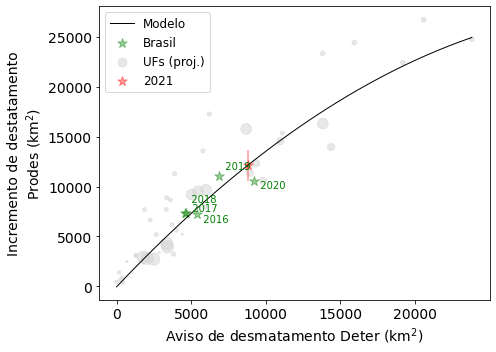

In [11]:
# Fit the model to all available data:
X = prodes_deter_uf_anual[['frac_area_deter']].values
y = prodes_deter_uf_anual['frac_incremento'].values
w = prodes_deter_uf_anual['weight']
model.fit(X, y, fit__sample_weight=w)

# Predict:
area_br = prodes_deter_uf_anual.groupby('ano_prodes')['Desmatavel'].sum().mean()
X_pred  = deter_br_agg.loc[deter_br_agg['ano_prodes'] == 2021, ['area_deter']].values / area_br
y_pred  = model.predict(X_pred)

pl.figure(figsize=(7,5))

# Plot model:
X_model = np.linspace(X.min(), X.max(), 50).reshape(-1,1)
y_model = model.predict(X_model)
pl.plot(X_model[:, 0] * area_br, y_model * area_br, color='k', linewidth=1, label='Modelo')

# Plot Brazil data:
pl.scatter(prodes_deter_br_anual['area_deter'], prodes_deter_br_anual['Incremento'], color='g', alpha=0.4, s=100, marker='*', label='Brasil')
text_yoffset = [0, 1000, 1800, 1500, 0]
for tx, ty, tt, to in zip(prodes_deter_br_anual['area_deter'], prodes_deter_br_anual['Incremento'], prodes_deter_br_anual['ano_prodes'], text_yoffset):
    pl.text(tx, ty + to, '  ' + str(tt), color='g', va='top')

# Plot UF data:
pl.scatter(prodes_deter_uf_anual['frac_area_deter'] * area_br, prodes_deter_uf_anual['frac_incremento'] * area_br, color='lightgray', alpha=0.5, s=prodes_deter_uf_anual['Desmatavel'] / 10000, label='UFs (proj.)')

# Plot Prediction:
pl.errorbar(X_pred[:, 0] * area_br, y_pred * area_br, yerr=model_error, color='r', marker=None, alpha=0.4, markersize=10)
pl.scatter(X_pred[:, 0] * area_br, y_pred * area_br, color='r', alpha=0.4, s=100, marker='*', label='2021')
    

pl.tick_params(labelsize=14)
pl.xlabel('Aviso de desmatamento Deter ($\mathrm{km^2}$)', fontsize=14)
pl.ylabel('Incremento de destatamento\nProdes ($\mathrm{km^2}$)', fontsize=14)
pl.legend(fontsize=12)
pl.tight_layout()
#pl.savefig('../resultados/plots/modelo_traducao_deter_prodes.png')
pl.show()

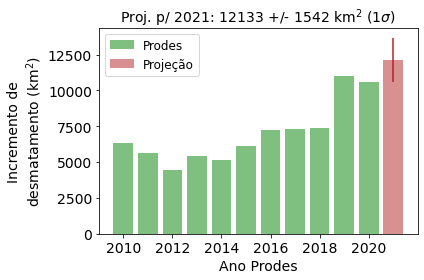

In [12]:
pl.title('Proj. p/ 2021: {:.0f} +/- {:.0f} km$^2$ ($1\sigma$)'.format(y_pred[0] * area_br, model_error), fontsize=14)
pl.bar(prodes_br['ano_prodes'], prodes_br['Incremento'], color='g', alpha=0.5, label='Prodes')
pl.bar([2021], y_pred * area_br, color='firebrick', alpha=0.5, label='Projeção')
pl.errorbar([2021], y_pred * area_br, yerr=model_error, color='firebrick')
pl.tick_params(labelsize=14)
pl.ylabel('Incremento de\ndesmatamento ($\mathrm{km^2}$)', fontsize=14)
pl.legend(fontsize=12)
pl.xlabel('Ano Prodes', fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/projecao_desmatamento_2021_deter_para_prodes.png')
pl.show()

#### Modelo linear para o Brasil todo

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error

In [13]:
# Cria modelo:
model = LinearRegression(fit_intercept=True, normalize=False)

In [14]:
# Select data:
X = prodes_deter_br_anual[['area_deter']].values
y = prodes_deter_br_anual['Incremento'].values

In [15]:
# Cross-validation:
train_scores = []
test_scores  = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    # Split:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Fit & predict:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
    test_scores.append(mean_squared_error(y_test, y_test_pred))
    #print("TRAIN:", train_index, "TEST:", test_index)

train_score = np.mean(train_scores)
test_score  = np.sqrt(np.mean(test_scores))

print('Train score: {:.1f}   Test score: {:.1f}'.format(train_score, test_score))

Train score: 762.3   Test score: 2114.2


In [16]:
# Ajuste final:
dump    = model.fit(X, y)
y_model = model.predict(X)
X_pred  = deter_br_agg.loc[deter_br_agg['ano_prodes'] == 2021, ['area_deter']].values
y_pred  = model.predict(X_pred)

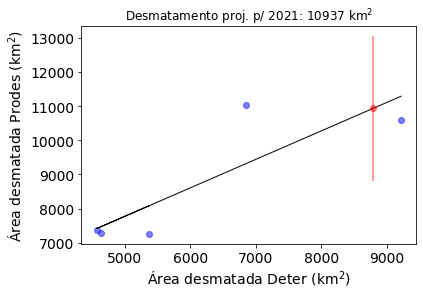

In [17]:
# Plot dos resultados:
pl.title('Desmatamento proj. p/ 2021: {:.0f} km$^2$'.format(y_pred[0]))
pl.scatter(X[:, 0], y, alpha=0.5, color='b')
pl.plot(X[:, 0], y_model, color='k', linewidth=1)
pl.errorbar(X_pred, y_pred, yerr=test_score, marker='o', color='r', alpha=0.5)
pl.tick_params(labelsize=14)
pl.xlabel('Área desmatada Deter ($\mathrm{km^2}$)', fontsize=14)
pl.ylabel('Área desmatada Prodes ($\mathrm{km^2}$)', fontsize=14)
pl.show()

In [24]:
# Run grid search:
param_grid = {'fit_intercept': [True], 'normalize': [False]}
grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
history = grid.fit(X, y)
best_model = grid.best_estimator_
prodes_deter_br_anual['prodes_pred'] = best_model.predict(X)
best_model_error = np.sqrt(-grid.best_score_)
print('Test score: {:.1f}'.format(best_model_error))

Test score: 2114.2


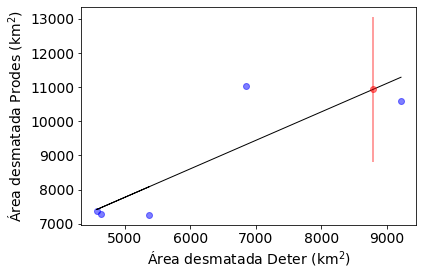

In [25]:
# Plot dos resultados:
pl.scatter(prodes_deter_br_anual['area_deter'], prodes_deter_br_anual['Incremento'], alpha=0.5, color='b')
pl.plot(prodes_deter_br_anual['area_deter'], prodes_deter_br_anual['prodes_pred'], color='k', linewidth=1)
pl.errorbar(deter_br_agg.loc[deter_br_agg['ano_prodes'] == 2021, 'area_deter'], 
            best_model.predict(deter_br_agg.loc[deter_br_agg['ano_prodes'] == 2021, ['area_deter']]), yerr=best_model_error, marker='o', color='r', alpha=0.5)
pl.tick_params(labelsize=14)
pl.xlabel('Área desmatada Deter ($\mathrm{km^2}$)', fontsize=14)
pl.ylabel('Área desmatada Prodes ($\mathrm{km^2}$)', fontsize=14)
pl.show()

# Explorando dados do DETER (INPE)

In [101]:
import pandas as pd
import matplotlib.pyplot as pl

import utils as xu

O documento explicando a metodologia do acompanhamento do desmatamento pelo INPE pode ser encontrado aqui: <http://www.obt.inpe.br/OBT/assuntos/programas/amazonia/prodes/pdfs/Metodologia_Prodes_Deter_revisada.pdf>

## Dados auxiliares (PRODES)

In [22]:
prodes_terra = pd.read_csv('../dados/brutos/desmatamento/terrabrasilis_prodes/terrabrasilis_legal_amazon_2021-07-07.csv')

## TerraBrasilis

**Como obter os dados**

Esses dados foram obtidos aqui: <http://terrabrasilis.dpi.inpe.br/app/dashboard/alerts/legal/amazon/aggregated/#>

Basta clicar em "Gráficos - Agregado Mensal: Amazônia Legal" na barra lateral esquerda, escolher "Avisos de desmatamento", escolher "Ano Civil" ou "Ano de referência" no canto superior direito. Em seguida, clicar na opção "Baixas dados" da barra lateral e escolher a opção "Com filtros".

**Notas explicativas** _(com base no documento de metodologia acima)_

* Avisos de desmatamento são mais definitivos que avisos de degradação: os últimos podem depois virar os primeiros com o avanço da degradação. Por isso, vamos utilizar os avisos de desmatamento.
* O chamado "ano de referência" começa em 01 de agosto de um ano civil e vai até o 31 de julho do ano civil seguinte. Esse é o ciclo de análise dos dados de desmatamento, que concentram a data de referência do desmatamento em um determinado ano naquela ondem existem maior quantidade de imagens sem nuvens, que é na seca. Por exemplo a taxa divulgada para o ano PRODES 2018 estima o desmatamento ocorrido entre 01/08/2017 e 31/07/2018.

### Carregando os dados

In [153]:
deter_ref = pd.read_csv('../dados/brutos/desmatamento/terrabrasilis_deter/deter_desmatamento_ano-referencia_2021-07-07.csv')
deter_civ = pd.read_csv('../dados/brutos/desmatamento/terrabrasilis_deter/deter_desmatamento_ano-civil_2021-07-07.csv')

### Comparando taxas Deter c/ Prodes

In [154]:
# Carrega tradutor estado -> sigla:
uf_sigla_nome = pd.read_csv('../dados/brutos/aux/uf_siglas_nomes.csv')
uf2sigla = dict(zip(uf_sigla_nome['uf'].str.upper(), uf_sigla_nome['sigla_uf']))

In [155]:
# Agrega dados do prodes por ano e UF:
prodes_terra['uf'] = prodes_terra['state'].map(uf2sigla)
agg_prodes = prodes_terra.groupby(['year', 'uf'])['areakm'].sum().reset_index()
agg_prodes = agg_prodes.loc[agg_prodes['year'] >= 2016]

In [156]:
# Agrega dados do deter por ano e UF:
deter_ref['year_prodes'] = deter_ref['year'].str.extract('/(\d{4})', expand=False).astype(int)
agg_deter = deter_ref.groupby(['year_prodes', 'uf'])['area'].sum().reset_index()
agg_deter = agg_deter.loc[agg_deter['year_prodes'] <= 2020]
#agg_deter = deter_civ.groupby(['year', 'uf'])['area'].sum().reset_index()
#agg_deter = agg_deter.loc[agg_deter['year'] <= 2020]

In [157]:
# Junta as duas bases:
merged = agg_prodes.merge(agg_deter, how='outer', left_on=['year', 'uf'], right_on=['year_prodes', 'uf'])
#merged = agg_prodes.merge(agg_deter, how='outer', on=['year', 'uf'])
merged['area'].fillna(0, inplace=True)
merged['year_prodes'].fillna(merged['year'], inplace=True)
merged['year_prodes'] = merged['year_prodes'].astype(int)
merged.rename({'area': 'area_deter', 'areakm': 'area_prodes'}, inplace=True, axis=1)
merged['diff'] = merged['area_deter'] - merged['area_prodes']
merged['frac_diff'] = merged['diff'] / merged['area_prodes']

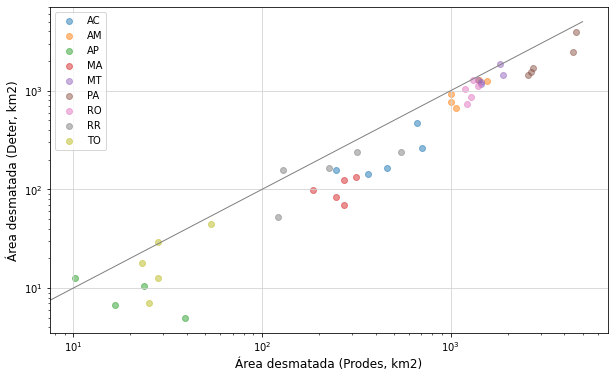

In [158]:
pl.figure(figsize=(10,6))
ufs = merged['uf'].unique()
for uf in ufs:
    merged_uf = merged.loc[merged['uf'] == uf]
    pl.scatter(merged_uf['area_prodes'], merged_uf['area_deter'], marker='o', alpha=0.5, label=uf)
x = [0, 5000]
pl.plot(x,x, color='gray', linewidth=1)
pl.grid(color='lightgray')
pl.xlabel('Área desmatada (Prodes, km2)', fontsize=12)
pl.ylabel('Área desmatada (Deter, km2)', fontsize=12)
pl.legend()
pl.yscale('log')
pl.xscale('log')
pl.show()

<AxesSubplot:>

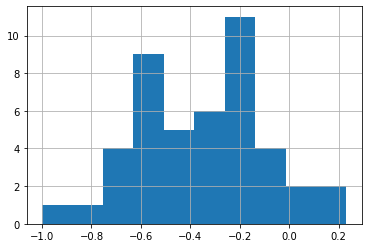

In [159]:
merged['frac_diff'].hist()

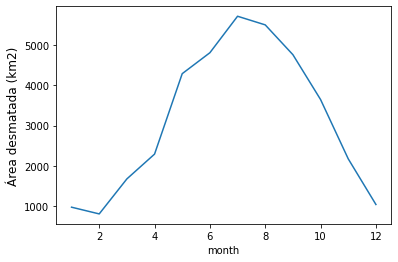

In [174]:
deter_tab = deter_civ.groupby(['month'])['area'].sum()
deter_tab.plot()
pl.ylabel('Área desmatada (km2)', fontsize=12)
pl.show()

### Certificando relação entre ano civil e de referência

In [13]:
ano_prodes = 2020
no_yr_cols = ['month', 'area', 'uf', 'className', 'numPol']
sel_civ = deter_civ.loc[((deter_civ['year'] == ano_prodes - 1) & (deter_civ['month'] >= 8)) | ((deter_civ['year'] == ano_prodes) & (deter_civ['month'] < 8)), no_yr_cols]
sel_ref = deter_ref.loc[deter_ref['year'] == '{}/{}'.format(ano_prodes - 1, ano_prodes), no_yr_cols]
check = (sel_civ == sel_ref)
check.all()

month         True
area          True
uf           False
className     True
numPol        True
dtype: bool

In [14]:
sel_ref.loc[check['uf'] == False]

,month,area,uf,className,numPol
474,4,0.0,NaN,DESMATAMENTO_VEG,1
505,3,0.0,NaN,DESMATAMENTO_VEG,3
543,7,0.0,NaN,DESMATAMENTO_CR,2
787,6,0.0,NaN,DESMATAMENTO_CR,3


In [39]:
sel_civ.loc[check['uf'] == False]

,month,area,uf,className,numPol
474,4,0.0,NaN,DESMATAMENTO_VEG,1
505,3,0.0,NaN,DESMATAMENTO_VEG,3
543,7,0.0,NaN,DESMATAMENTO_CR,2
787,6,0.0,NaN,DESMATAMENTO_CR,3


## Shapefiles

Esses dados de shapefiles podem ser obtidos no link: <http://www.dpi.inpe.br/obt/deter/dados/> ou neste <http://terrabrasilis.dpi.inpe.br/downloads/>.
        
Mais informações aqui: <http://www.obt.inpe.br/OBT/assuntos/programas/amazonia/deter/deter>  ou aqui: <http://www.obt.inpe.br/OBT/assuntos/programas/amazonia/prodes/pdfs/Metodologia_Prodes_Deter_revisada.pdf>

In [1]:
import geopandas as gp

In [2]:
#df = gp.read_file('../dados/brutos/desmatamento/Deter_201711_shp/Deter_201711.shp')
df = gp.read_file('../dados/brutos/desmatamento/deter-amz-public-2021jul07/deter_public.shp')

In [9]:
deter_br_agg

,ano_prodes,area_deter
0,2016,5377.08
1,2017,4639.37
2,2018,4570.63
3,2019,6843.91
4,2020,9215.88
5,2021,8792.89
6,2022,194.94


In [7]:
xu.checkMissing(df)

Colunas com valores faltantes:
        coluna         N      %
1     QUADRANT  162650.0  76.66
7           UC  202265.0  95.33
9   MUNICIPALI      12.0   0.01
10          UF      12.0   0.01


In [13]:
xu.mapUnique(df.iloc[:, :-1])


CLASSNAME: 8 unique values.
CICATRIZ_DE_QUEIMADA,  CORTE_SELETIVO,  CS_DESORDENADO,  CS_GEOMETRICO,  DEGRADACAO,  DESMATAMENTO_CR,  DESMATAMENTO_VEG,  MINERACAO

QUADRANT: 5 unique values.
A,  B,  C,  D,  None

PATH_ROW: 466 unique values.
(sample) 158111,  160117,  171117,  175117,  177111,  185099,  188105,  219124,  224132,  314082,  314087,  316080,  317088,  320082,  320086,  322088,  323090,  324087,  325079,  327080

VIEW_DATE: 1315 unique values.
(sample) 2016-08-08,  2017-01-15,  2018-06-03,  2018-06-26,  2018-09-14,  2019-04-15,  2019-12-05,  2019-12-18,  2019-12-20,  2020-05-26,  2020-06-04,  2020-07-01,  2020-08-11,  2020-09-10,  2020-09-30,  2021-04-13,  2021-05-16,  2021-05-20,  2021-05-25,  2021-06-07

SENSOR: 3 unique values.
AWFI,  AWIFS,  WFI

SATELLITE: 3 unique values.
CBERS-4,  CBERS-4A,  RESOURCESAT-2

AREAUCKM: 9872 unique values.
(sample) 0.0626401026028004,  0.0662442088229456,  0.0666624969862401,  0.0823604471017226,  0.0841775688476562,  0.0854493220058382,